In [1]:
import numpy as np
import proplot as pplt
import fitsio
import glob

%matplotlib inline

In [54]:
fnames = glob.glob("cat_*", recursive=True)

d = np.concatenate([fitsio.read(f, lower=True) for f in fnames])

In [59]:
msk = (
    (d["mask_flags"] == 0)
    & (d["flags"] == 0)
    & (d["mdet_s2n"] > 10)
    & (d["mdet_t_ratio"] > 1.2)
    & (d["mfrac"] < 0.1)
)

bin_edges = np.quantile(
    np.hstack([d["psfrec_g_1"][msk], d["psfrec_g_2"][msk]]), 
    np.linspace(0, 1, 16),
)
print(bin_edges)    

[-2.59658135e-01 -1.63830500e-02 -1.23423409e-02 -9.74912675e-03
 -7.67673964e-03 -5.90821885e-03 -4.26948475e-03 -2.71923121e-03
 -1.22685253e-03  2.77857553e-04  1.89453868e-03  3.70081124e-03
  5.69190002e-03  8.17618851e-03  1.18153624e-02  7.81977466e-01]


In [60]:
def _bin_stats(bin_edges, binvals, mdet_step, g1, g2):
    binds = np.searchsorted(bin_edges, binvals, side='left')
    binds = np.clip(binds, 0, len(bin_edges)-2)
    
    res = {}
    for col in ["g1", "g2", "g1p", "g1m", "g2p", "g2m"]:
        res[col] = np.zeros(len(bin_edges)-1)
        res["n_%s" % col] = np.zeros(len(bin_edges)-1)
    
    for step in ["noshear", "1p", "1m", "2p", "2m"]:
        msk = mdet_step == step
        if step == "noshear":
            np.add.at(res["g1"], binds[msk], g1[msk])
            np.add.at(res["n_g1"], binds[msk], 1)
            np.add.at(res["g2"], binds[msk], g2[msk])
            np.add.at(res["n_g2"], binds[msk], 1)
        elif step == "1p":
            np.add.at(res["g1p"], binds[msk], g1[msk])
            np.add.at(res["n_g1p"], binds[msk], 1)
        elif step == "1m":
            np.add.at(res["g1m"], binds[msk], g1[msk])
            np.add.at(res["n_g1m"], binds[msk], 1)
        elif step == "2p":
            np.add.at(res["g2p"], binds[msk], g2[msk])
            np.add.at(res["n_g2p"], binds[msk], 1)
        elif step == "2m":
            np.add.at(res["g2m"], binds[msk], g2[msk])
            np.add.at(res["n_g2m"], binds[msk], 1)
    return res

In [87]:
res = _bin_stats(
    bin_edges, 
    d["psfrec_g_1"][msk], 
    d["mdet_step"][msk], 
    d["mdet_g_1"][msk], 
    d["mdet_g_2"][msk],
)

In [91]:
R11 = (res["g1p"]/res["n_g1p"] - res["g1m"]/res["n_g1m"])
g1 = res["g1"]/res["n_g1"]

R22 = (res["g2p"]/res["n_g2p"] - res["g2m"]/res["n_g2m"])
g2 = res["g2"]/res["n_g2"]

Rbar = np.mean(R11) + np.mean(R22)

<a list of 1 Line2D objects>

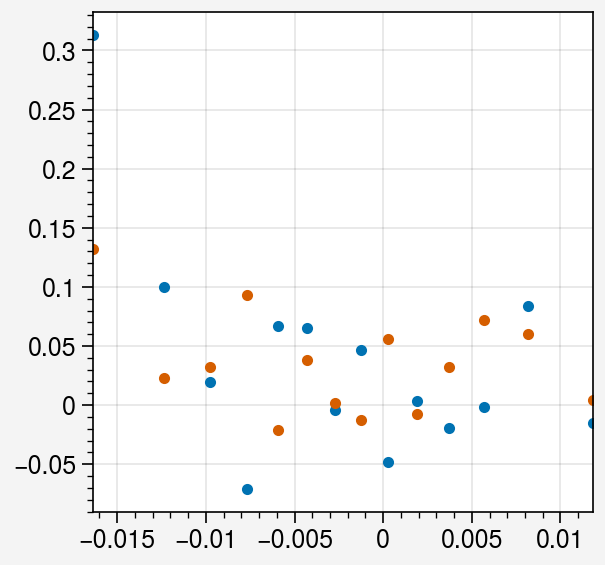

In [92]:
fig, axs = pplt.subplots()
axs.plot(bin_edges[:-1][res["n_g1"] > 1e1], (g1/Rbar)[res["n_g1"] > 1e1], ".")
axs.plot(bin_edges[:-1][res["n_g2"] > 1e1], (g2/Rbar)[res["n_g2"] > 1e1], ".")

In [93]:
d.dtype.names

('id',
 'slice_id',
 'mdet_step',
 'ra',
 'dec',
 'ra_det',
 'dec_det',
 'row_det',
 'col_det',
 'irow',
 'icol',
 'slice_row',
 'slice_col',
 'slice_row_det',
 'slice_col_det',
 'mask_flags',
 'filename',
 'tilename',
 'flags',
 'mdet_flags',
 'mdet_s2n',
 'mdet_t',
 'mdet_t_err',
 'mdet_g_1',
 'mdet_g_2',
 'mdet_g_cov_1_1',
 'mdet_g_cov_1_2',
 'mdet_g_cov_2_1',
 'mdet_g_cov_2_2',
 'psf_g_1',
 'psf_g_2',
 'psf_t',
 'mdet_t_ratio',
 'mdet_band_flux_flags',
 'mdet_r_flux',
 'mdet_i_flux',
 'mdet_z_flux',
 'mdet_r_flux_err',
 'mdet_i_flux_err',
 'mdet_z_flux_err',
 'ormask',
 'mfrac',
 'bmask',
 'psfrec_flags',
 'psfrec_g_1',
 'psfrec_g_2',
 'psfrec_t')

In [95]:
len(np.unique(d["tilename"]))

39